In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import numpy as np
from h5py import File

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output")

rc = {
    # "figure.facecolor": "#FFFFFF00",
    # "axes.facecolor": "#FFFFFF00",
    "legend.framealpha": 0.2,
    "lines.color": "k",
    "svg.fonttype": "none",
}

sns.set_context("paper")
sns.set_theme(style="ticks", font="Arial", rc=rc)

# print(mpl.font_manager.get_font_names())

In [63]:
nc_pal = {11: "coral", 12: "mediumseagreen", 13: "cadetblue", 14: "#895794"}

In [5]:
spots_dfs = []
metadatas = []

for i, spots_path in tqdm(enumerate(spots_directory.glob("*_spots.h5")), desc="reading spots dfs"):
    print(spots_path)
    spots_df = pd.read_hdf(spots_path, key="df")

    spots_df["source"] = i

    metadata = {}

    with File(spots_path, "r") as f:
        m = f["metadata"]
        metadata.update(m.attrs)

        # print(metadata)

    dtw_path = spots_directory / "dtw" / f"{spots_path.stem}_dtw.h5"
    if dtw_path.exists():
        dtw_update = pd.read_hdf(dtw_path, key="df")
        spots_df = pd.merge(
            spots_df, dtw_update, left_index=True, right_index=True, how="left"
        )
    else:
        spots_df["distance"] = np.nan  # rename this later
        spots_df["pseudotime"] = np.nan

    spots_dfs.append(spots_df)

reading spots dfs: 0it [00:00, ?it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20241104_spots.h5


reading spots dfs: 1it [00:00,  1.36it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250131_spots.h5


reading spots dfs: 2it [00:01,  1.38it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250206_spots.h5


reading spots dfs: 3it [00:02,  1.35it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250414_spots.h5


reading spots dfs: 4it [00:02,  1.32it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250625_spots.h5


reading spots dfs: 5it [00:04,  1.04it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250627_spots.h5


reading spots dfs: 6it [00:05,  1.01s/it]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250702_spots.h5


reading spots dfs: 7it [00:06,  1.01s/it]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250704_spots.h5


reading spots dfs: 8it [00:07,  1.06s/it]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250705_spots.h5


reading spots dfs: 9it [00:08,  1.15s/it]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250318_spots.h5


reading spots dfs: 10it [00:09,  1.09s/it]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250319a_spots.h5


reading spots dfs: 11it [00:10,  1.01s/it]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250319b_spots.h5


reading spots dfs: 12it [00:11,  1.07it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250321_spots.h5


reading spots dfs: 13it [00:12,  1.00s/it]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250325_spots.h5


reading spots dfs: 14it [00:13,  1.03it/s]


In [5]:
def get_mean_traj(df, cols, n=50):
    """
    Get mean trajectory for a given DataFrame `ss` and columns `cols`.
    Interpolates the data to `n` points.
    """
    pseudo_time = np.linspace(0, 1, n)

    interps = {col: list() for col in cols}

    mean_length = df.groupby("tracklet_id")[cols[0]].count().mean()

    for i, (tid, group) in enumerate(df.groupby("tracklet_id")):

        if np.abs(len(group) - mean_length) > 25:
            # print(f"skipping {tid} due to length mismatch")
            continue

        for col in cols:
            vals = group[col].rolling(5, 1, center=True).mean()
            vals = (vals - vals.mean()) / vals.std()

            st = np.arange(len(vals)) / len(vals)

            if np.sum(vals.isna()) > 0:
                print(f"skipping {tid} due to NaNs")
                continue

            x_interp = np.interp(pseudo_time, st, vals)
            interps[col].append(x_interp)

    for col in cols:
        interps[col] = np.array(interps[col])
        interps[col] = np.nanmean(interps[col], axis=0)

    return pseudo_time, interps

In [73]:
df = spots_dfs[7]
print(df.columns)

ss = df[df["cycle"] == 13].copy()
mean_length = ss.groupby("tracklet_id")["area"].count().mean()

# fig, ax = plt.subplots(1, 1, figsize=(5, 5))

n = 100

st, mean_trajectory = get_mean_traj(ss, ["radius", "intensity_mean", "time"], n=n)

y_traj = mean_trajectory["radius"]
x_traj = mean_trajectory["intensity_mean"]

from dtaidistance import dtw_ndim
from collections import defaultdict
from random import shuffle
import time

full_traj = np.stack([y_traj, x_traj], axis=1)

time_sequences = []
pseudotime_sequences = []
ap_positions = []
dtw_distances = []
theta_positions = []

def map_pseudotime(warping_path, pseudotime_full, len_this_traj):
    # Collect all j's for each i
    mapping = defaultdict(list)
    for i, j in warping_path:
        mapping[i].append(j)
    # For each i, compute the mean pseudotime of mapped j's
    pseudotime_mapped = np.full(len_this_traj, np.nan)
    for i, js in mapping.items():
        pseudotime_mapped[i] = np.mean(pseudotime_full[js])
    return pseudotime_mapped

grouped = ss.groupby('tracklet_id')
group_keys = list(grouped.groups.keys())


shuffle(group_keys)
for tid in tqdm(group_keys):
    group = grouped.get_group(tid)

    if np.abs(len(group) - mean_length) > 25:
        continue

    y = group["radius"].rolling(5, 1, center=True).mean()
    x = group["intensity_mean"].rolling(5, 1, center=True).mean()

    time_sequences.append(group["time_since_nc11"].values)
    ap_positions.append(group["AP"].mean())
    theta_positions.append(group["theta"].mean())

    y = (y - y.mean()) / y.std()
    x = (x - x.mean()) / x.std()

    this_traj = np.stack([y, x], axis=1)

    if np.sum(y.isna()) > 0 or np.sum(x.isna()) > 0:
        continue

    seq, dis = dtw_ndim.warping_path(this_traj.astype(np.double), full_traj.astype(np.double), include_distance=True)

    pseudotime_seq = map_pseudotime(seq, st, len(this_traj))
    pseudotime_sequences.append(pseudotime_seq)

    dtw_distances.append(dis)


# plt.scatter(y_traj, x_traj, zorder=3, color="k", s=2, label="mean trajectory")
# plt.show()
#
# dx = np.diff(x_traj)
# dy = np.diff(y_traj)
# eu_dis = np.sqrt(dx**2 + dy**2)
# total_dis = np.cumsum(eu_dis)
# total_dis = np.insert(total_dis, 0, 0)
#
#
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(mean_trajectory["time"], total_dis, lw=2, color="r", label="distance traveled")
# ax.plot(mean_trajectory["time"][1:], eu_dis, lw=2, color="b", label="distance traveled between points")
#
# plt.show()

Index(['index', 'time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area',
       'radius', 'intensity_mean', 'cycle', 'display_z', 'display_y',
       'display_x', 'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'source'],
      dtype='object')


 43%|████▎     | 1292/2988 [01:17<01:41, 16.69it/s]


KeyboardInterrupt: 

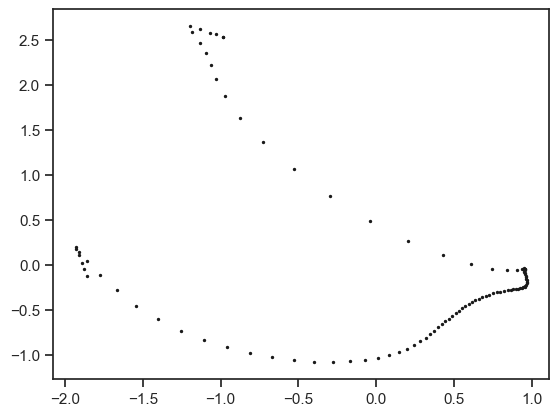

count    1254.000000
mean       28.328283
std         0.950150
min        21.000000
25%        28.000000
50%        28.000000
75%        28.333333
max        36.000000
dtype: float64
count    1254.000000
mean       24.258794
std         0.617444
min        17.666667
25%        24.000000
50%        24.222222
75%        24.444444
max        29.333333
dtype: float64
count    1254.000000
mean       -4.069489
std         0.625781
min       -10.333333
25%        -4.111111
50%        -4.000000
75%        -3.777778
max        -1.000000
dtype: float64


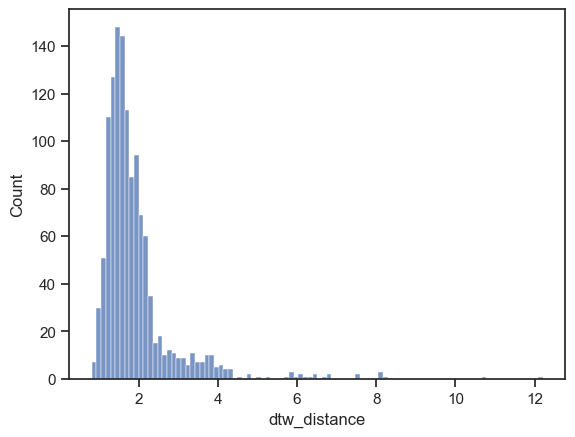

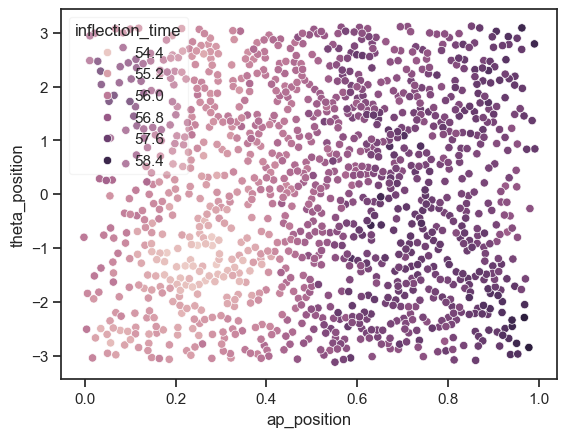

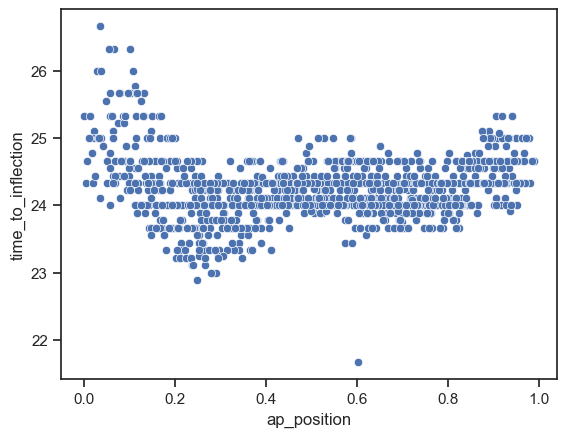

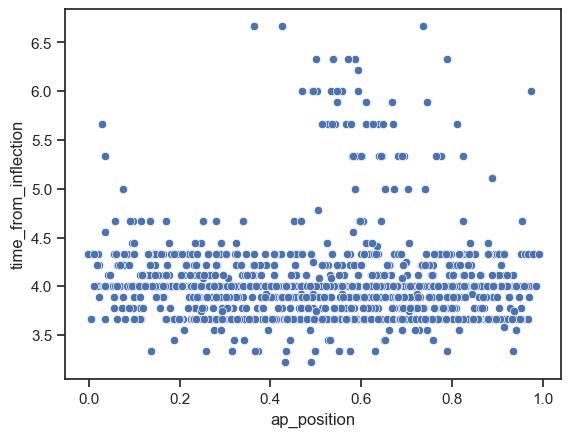

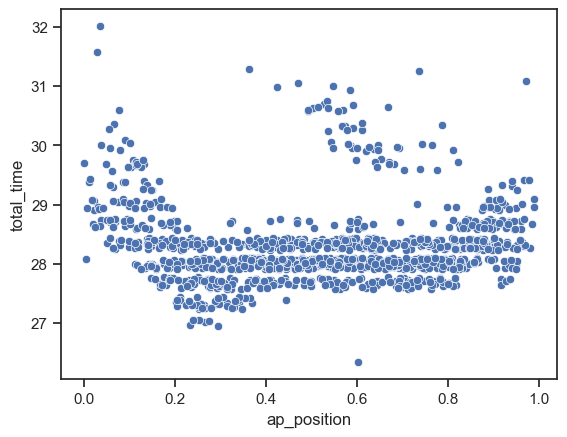

Fitting linear regression for start_time vs end_time
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     2035.
Date:                Fri, 18 Jul 2025   Prob (F-statistic):          1.59e-261
Time:                        18:27:00   Log-Likelihood:                -1203.4
No. Observations:                1213   AIC:                             2411.
Df Residuals:                    1211   BIC:                             2421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

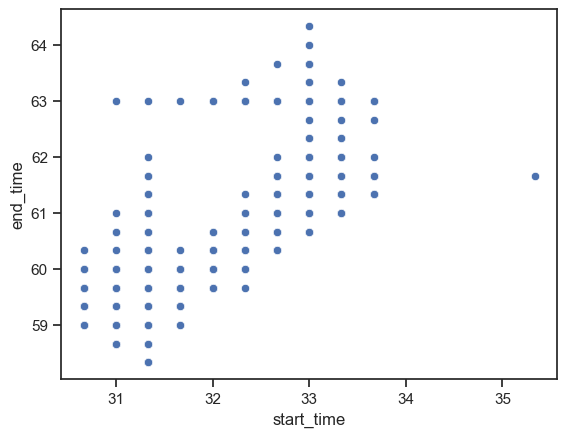

In [75]:
dx = np.diff(full_traj, axis=0)
dx = np.sqrt(dx[:, 0]**2 + dx[:, 1]**2)
st_inflection = st[np.argmax(dx)]

plt.scatter(full_traj[:, 0], full_traj[:, 1], color="k", s=2, label="mean trajectory")
plt.show()

stats = defaultdict(list)

for i in range(len(dtw_distances)):

    time_seq = time_sequences[i]
    pseudotime_seq = pseudotime_sequences[i]
    ap = ap_positions[i]
    theta = theta_positions[i]
    dis = dtw_distances[i]

    stats["start_time"].append(np.min(time_seq))
    stats["end_time"].append(np.max(time_seq))
    stats["inflection_time"].append(np.interp(st_inflection, pseudotime_seq, time_seq))
    stats["ap_position"].append(ap)
    stats["theta_position"].append(theta)
    stats["dtw_distance"].append(dis)

    # plt.plot(pseudotime_seq, time_seq, lw=1, alpha=0.5)

# plt.show()

stats = pd.DataFrame(stats)

print((stats["end_time"] - stats["start_time"]).describe())
print((stats["inflection_time"] - stats["start_time"]).describe())
print((stats["inflection_time"] - stats["end_time"]).describe())

stats["time_to_inflection"] = stats["inflection_time"] - stats["start_time"]
stats["time_from_inflection"] = stats["end_time"] - stats["inflection_time"]
stats["total_time"] = stats["end_time"] - stats["start_time"]

sns.histplot(x=stats["dtw_distance"])
plt.show()

stats = stats[stats["dtw_distance"] < 4]

sns.scatterplot(stats, x="ap_position", y="theta_position", hue="inflection_time")
plt.show()



def jitter(x, jitter=0.1):
    return x + np.random.uniform(-jitter, jitter, size=len(x))

# sns.scatterplot(data=stats, x="ap_position", y="time_to_inflection")
sns.scatterplot(data=stats, x="ap_position", y="time_to_inflection")
plt.show()

sns.scatterplot(data=stats, x="ap_position", y="time_from_inflection")
plt.show()

sns.scatterplot(x=stats["ap_position"], y=jitter(stats["total_time"]))
plt.show()

# from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def fit_linear(data, x_col, y_col):
    # with_intercept = sm.add_constant(data[x_col].values)
    print(f"Fitting linear regression for {x_col} vs {y_col}")

    reg = sm.OLS(data[y_col].values, sm.add_constant(data[x_col].values)).fit()
    print(reg.summary())

    return reg


# sns.scatterplot(x=jitter(stats["total_time"]), y=stats["time_to_inflection"])

x_factor = "start_time"
y_factor = "end_time"

# sns.scatterplot(y=stats["time_to_inflection"], x=jitter(stats["total_time"]))
sns.scatterplot(x=stats[x_factor], y=stats[y_factor])

fit_linear(stats, x_factor, y_factor)

plt.show()

[np.float64(477.46697017923043), np.float64(487.01234126879234), np.float64(498.73923867490595), np.float64(458.544775320738), np.float64(487.7932079777313), np.float64(512.1230388071555), np.float64(496.098232546807), np.float64(507.51338713155894), np.float64(495.6571647024368), np.float64(481.80721016016076), np.float64(483.67978415401893), np.float64(471.6189031910791), np.float64(458.46924159401027), np.float64(473.8987302322878)]


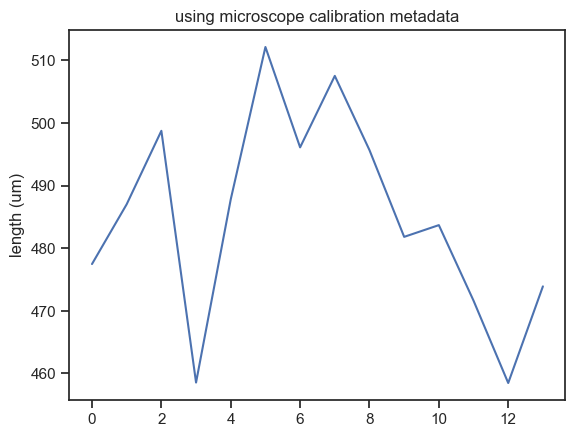

In [6]:
lengths = []

for i, df in enumerate(spots_dfs):

    length = df["AP_um"].quantile(0.99) - df["AP_um"].quantile(0.01)
    if (i in [4, 5]):
        length = length / (0.65/0.525)

    if not (i in [6, 7, 8]):
        length = length * 1.11

    lengths.append(length)


print(lengths)
plt.plot(lengths)
plt.title("corrected")
plt.title("using microscope calibration metadata")
plt.ylabel("length (um)")
plt.show()

8
1320
0.20366184443061341
[1.21880879e-268 3.23174413e-067]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     337.1
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           3.23e-67
Time:                        18:16:51   Log-Likelihood:                -252.97
No. Observations:                1320   AIC:                             509.9
Df Residuals:                    1318   BIC:                             520.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

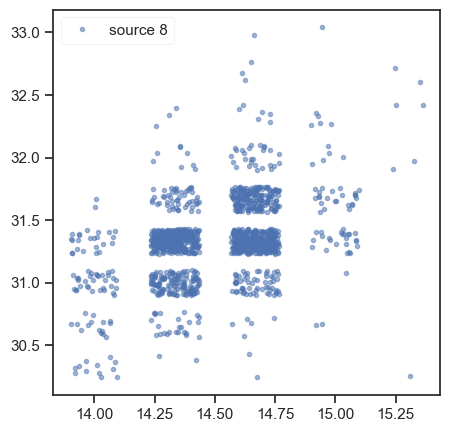

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i, df in enumerate(spots_dfs):
    if df["trk"].values[0]:
        continue

    if i != 8:
        continue

    print(df["source"].values[0])

    ss = df[df["cycle"] == 12].copy()

    tracklet_starts = ss.groupby("tracklet_id")["time_since_nc11"].min()
    tracklet_ends = ss.groupby("tracklet_id")["time_since_nc11"].max()

    good_tracklets = ((tracklet_starts >= tracklet_starts.quantile(0.05)) *
                      (tracklet_ends <= tracklet_ends.quantile(0.95)) *
                       (tracklet_starts <= tracklet_starts.quantile(0.95)) *
                        (tracklet_ends >= tracklet_ends.quantile(0.05)))

    tracklet_starts = tracklet_starts[good_tracklets]
    tracklet_ends = tracklet_ends[good_tracklets]

    with_intercept = sm.add_constant(tracklet_starts.values)
    reg = sm.OLS(tracklet_ends.values, with_intercept).fit()

    print(len(tracklet_starts))

    print(reg.rsquared)
    print(reg.pvalues)
    print(reg.summary())

    plt.plot(jitter(tracklet_starts), jitter(tracklet_ends), "o", alpha=0.5, markersize=3, label=f"source {i}")

plt.legend()

plt.show()



In [13]:
all_spots = pd.concat(spots_dfs, ignore_index=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

12_wt vs. 12_trk: t-test independent samples, P_val:6.710e-01 t=-4.355e-01
11_wt vs. 11_trk: t-test independent samples, P_val:3.197e-01 t=1.038e+00
13_wt vs. 13_trk: t-test independent samples, P_val:1.865e-01 t=-1.401e+00


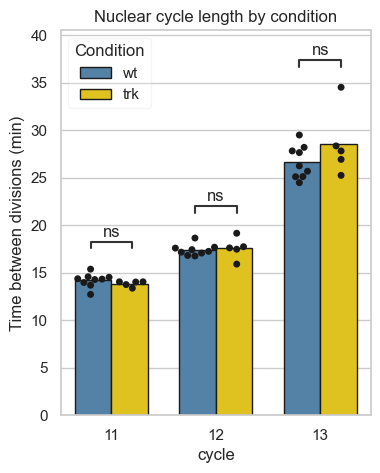

In [14]:
### plot nuclear cycle lengths
from statannotations.Annotator import Annotator

tracklets = all_spots.groupby(["source", "cycle", "tracklet_id"])

var_lengths = tracklets["time"].max() - tracklets["time"].min()
# var_lengths = tracklets["time"].count()
avg = var_lengths.groupby(["source", "cycle"]).mean()
trk = all_spots.groupby(["source", "cycle"])["trk"].first()
condition = trk.map({True: "trk", False: "wt"})

stacked = pd.concat([avg, trk], axis=1).reset_index()
stacked["Condition"] = condition.values
subset = stacked[stacked["cycle"].isin([11, 12, 13])].copy()
# subset = stacked.copy()

fig, ax = plt.subplots(1,1, figsize=(4, 5))

x = "cycle"
y = "time"
hue = "Condition"
hue_order = ["wt", "trk"]

pal = ["cadetblue", "burlywood"]
pal = ["fuchsia", "magenta"]
pal = ["steelblue", "gold"]

sns.barplot(data=subset, x=x, y=y, hue=hue, palette=pal, hue_order=hue_order, ax=ax, width=0.7, errorbar=None, edgecolor="k")
sns.swarmplot(data=subset, x=x, y=y, hue=hue, palette=["k", "k"], order=[11, 12, 13], dodge=True, hue_order=hue_order, ax=ax, legend=False)

pairs = [((cycle, "trk"), (cycle, "wt")) for cycle in [ 11, 12, 13]]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=subset, x=x, y=y, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel(f"Time between divisions (min)")
plt.xlabel("cycle")
# ax.legend(title="")
plt.title(f"Nuclear cycle length by condition")
plt.savefig(save_path / f"time_between_divisions.svg", dpi=300)
plt.show()

In [7]:
from collections import defaultdict

wave_fronts = defaultdict(list)

for cycle in [11, 12, 13]:

    for i, df in enumerate(spots_dfs):

        t = df[df["cycle"] == cycle].groupby("tracklet_id")

        x = pd.cut(np.clip(t["AP"].last(), 0, 1), 40)
        x = np.array(x.apply(lambda v: (v.left + v.right) / 2))
        y = np.array(t["time"].max())

        y = y - np.mean(y)

        bg = t["time"].max().groupby(x, observed=True).mean()

        a_half = bg[bg.index < 0.5]
        mean_a = a_half.index[a_half.argmin()]
        p_half = bg[(bg.index > 0.5) * (bg.index < 0.95) ]
        mean_p = p_half.index[p_half.argmin()]

        wave_fronts["condition"].append("Trk-null" if df["trk"].min() else "Wild Type")
        wave_fronts["cycle"].append(cycle)
        wave_fronts["anterior"].append(mean_a)
        wave_fronts["posterior"].append(1 - mean_p)
        wave_fronts["wave_magnitude"].append(np.mean(np.abs(y)))

        cycle_length = np.array(t["time"].max()) - np.array(t["time"].mean())

        wave_fronts["length_magnitude"].append(np.mean(np.abs(cycle_length - cycle_length.mean())))


wave_fronts = pd.DataFrame(wave_fronts)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

12_Wild Type vs. 12_Trk-null: t-test independent samples, P_val:3.416e-01 t=9.901e-01
13_Wild Type vs. 13_Trk-null: t-test independent samples, P_val:3.835e-01 t=9.045e-01


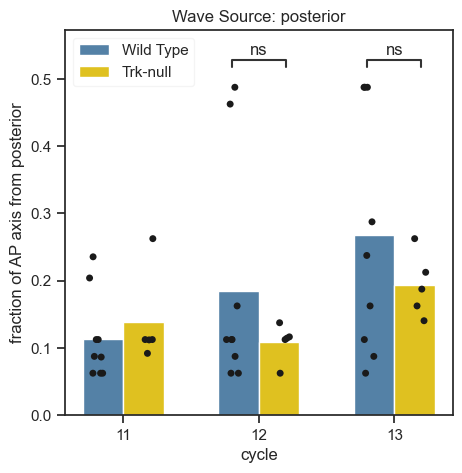

In [8]:
from statannotations.Annotator import Annotator

fig, ax = plt.subplots(1,1, figsize=(5, 5))

x = "cycle"
y = "posterior"
hue = "condition"
hue_order = ["Wild Type", "Trk-null"]

sns.barplot(data=wave_fronts, x=x, y=y, hue=hue, palette=pal, hue_order=hue_order, ax=ax, width=0.6, errorbar=None)
sns.stripplot(data=wave_fronts, x=x, y=y, hue=hue, palette=["k", "k"], order=[11, 12, 13], dodge=True, hue_order=hue_order, ax=ax, legend=False)

pairs = [((cycle, "Wild Type"), (cycle, "Trk-null")) for cycle in [12, 13]]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=wave_fronts, x=x, y=y, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel(f"fraction of AP axis from {y}")
plt.xlabel("cycle")
ax.legend(title="")
plt.title(f"Wave Source: {y}")
plt.savefig(save_path / f"wave_source_{y}.png", dpi=300)
plt.show()

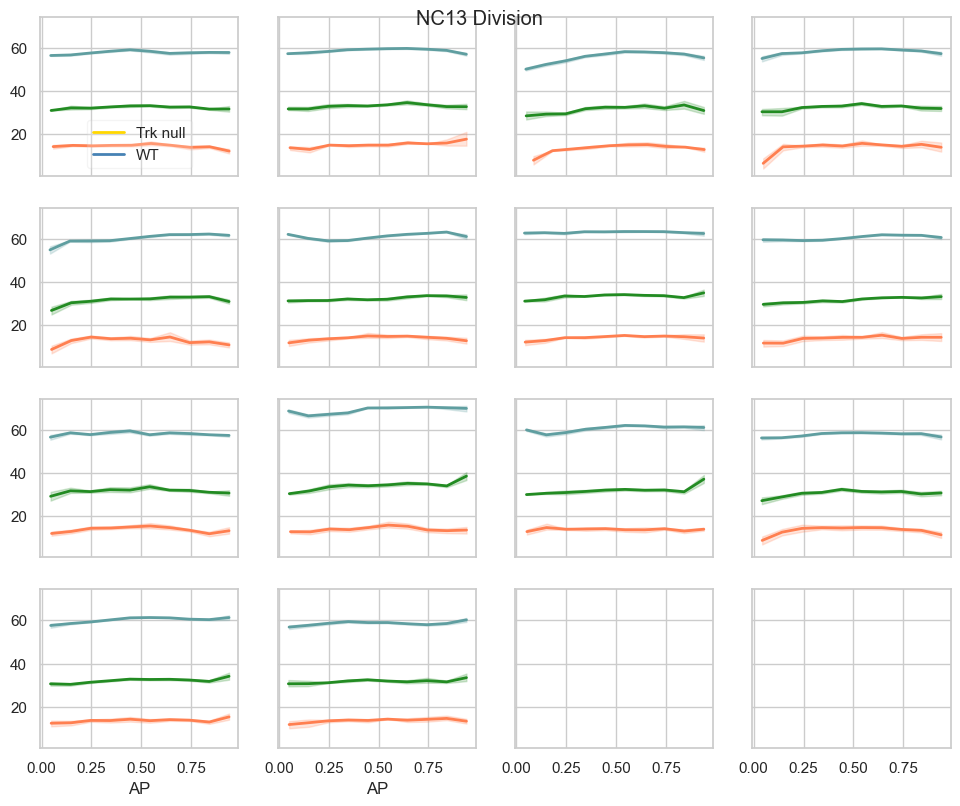

In [22]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(4, 4, figsize=(10, 8), sharex=True, sharey=True)
cycle = 13

plt.tight_layout()


for i, (df, ax) in enumerate(zip(spots_dfs, axes.flatten())):

    trk = df["trk"].min()

    color = pal[int(trk)]

    df = df[df["AP"] < 0.99]

    for j, cycle in enumerate([11, 12, 13]):

        color = nc_pal[cycle]

        t = df[df["cycle"] == cycle].groupby("tracklet_id")

        x = pd.cut(t["AP"].last(), 10)
        x = x.apply(lambda v: (v.left + v.right) / 2)
        y = np.array(t["time_since_nc11"].max())

        # y = y - np.mean(y)

        sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="band", color=color, lw=2)
        # sns.scatterplot(x=t["AP"].last(), y=y, ax=ax, color=color, s=4, alpha=0.5)

        # ax.set_ylim(-5, 5)

#
# custom_lines = [Line2D([0], [0], color=pal[1], lw=2),
#                 Line2D([0], [0], color=pal[0], lw=2)]
#
# axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_{cycle}_line.png", dpi=300)
plt.suptitle(f"NC{cycle} Division")

plt.show()

    cycle  trk     qupper     qlower       mean     range
0      11   wt  15.400000  14.666667  14.712564  0.733333
1      12   wt  32.633333  31.900000  32.643592  0.733333
2      13   wt  59.033333  57.566667  57.917629  1.466667
3      11   wt  15.400000  15.033333  15.406597  0.366667
4      12   wt  33.366667  32.633333  33.339174  0.733333
5      13   wt  59.400000  58.300000  58.871685  1.100000
6      11   wt  14.666667  13.666667  14.030303  1.000000
7      12   wt  32.333333  30.666667  31.891231  1.666667
8      13   wt  57.666667  55.333333  56.178626  2.333333
9      11   wt  15.333333  14.666667  14.190544  0.666667
10     12   wt  33.666667  32.666667  32.721843  1.000000
11     13   wt  59.333333  58.333333  58.556485  1.000000
12     11   wt  15.000000  14.333333  12.936742  0.666667
13     12   wt  33.333333  31.666667  31.943903  1.666667
14     13   wt  62.000000  59.333333  60.503089  2.666667
15     11   wt  15.333333  14.333333  14.079639  1.000000
16     12   wt

(<Axes: xlabel='cycle', ylabel='range'>,
  <statannotations.Annotation.Annotation at 0x28190d78f90>])

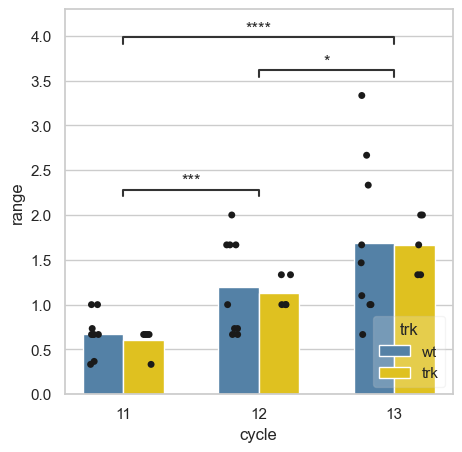

In [60]:
from collections import defaultdict

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

stats = defaultdict(list)

for i, df in enumerate(spots_dfs):

    for cycle in [11, 12, 13]:

        t = df[df["cycle"] == cycle].groupby("tracklet_id")

        tracklet_ends = t["time_since_nc11"].max()

        stats["cycle"].append(cycle)
        stats["trk"].append("trk" if df["trk"].values[0] else "wt")
        stats["qupper"].append(tracklet_ends.quantile(0.75))
        stats["qlower"].append(tracklet_ends.quantile(0.25))
        stats["mean"].append(tracklet_ends.mean())

stats = pd.DataFrame(stats)
stats["range"] = stats["qupper"] - stats["qlower"]
print(stats)

sns.barplot(data=stats, x="cycle", y="range", hue="trk", palette=pal, hue_order=["wt", "trk"], ax=ax, width=0.6, errorbar=None)
sns.stripplot(data=stats, x="cycle", y="range", hue="trk", palette=["k", "k"], order=[11, 12, 13], dodge=True, hue_order=["wt", "trk"], ax=ax, legend=False)

pairs = [(11, 12), (11, 13), (12, 13)]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=stats, x="cycle", y="range", order=[11, 12, 13],)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()


    cycle  source trk     qupper     qlower       mean     range
0      11       0  wt   0.733333  -0.366667   0.166731  1.100000
1      12       0  wt  15.766667  14.666667  15.314529  1.100000
2      13       0  wt  33.366667  31.533333  32.577031  1.833333
3      14       0  wt  59.400000  56.100000  58.132141  3.300000
4      11       1  wt   0.366667  -0.733333   0.026237  1.100000
5      12       1  wt  16.133333  14.666667  15.644143  1.466667
6      13       1  wt  34.100000  31.533333  33.172900  2.566667
7      14       1  wt  59.766667  57.200000  58.820582  2.566667
8      11       2  wt   0.000000  -1.333333  -0.270136  1.333333
9      12       2  wt  15.000000  12.000000  14.335710  3.000000
10     13       2  wt  33.000000  27.666667  31.619425  5.333333
11     14       2  wt  58.333333  50.000000  56.172778  8.333333
12     11       3  wt   0.666667  -0.666667   0.006101  1.333333
13     12       3  wt  16.000000  14.666667  15.399945  1.333333
14     13       3  wt  34

(<Axes: xlabel='cycle', ylabel='range'>,
  <statannotations.Annotation.Annotation at 0x2818ff75010>])

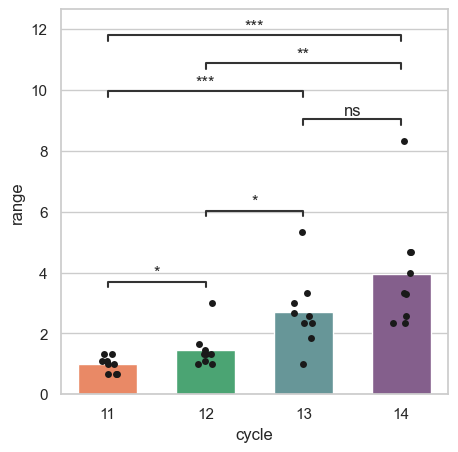

In [66]:
from collections import defaultdict

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

stats = defaultdict(list)

for i, df in enumerate(spots_dfs):

    if df["trk"].values[0]:
        continue

    for cycle in [11, 12, 13, 14]:

        cc = cycle if cycle != 14 else 13

        t = df[(df["cycle"] == cc) &
               (df["distance"] < 3)].groupby("tracklet_id")

        tracklet_ends = t["time_since_nc11"].min() if cycle != 14 else t["time_since_nc11"].max()

        stats["cycle"].append(cycle)
        stats["source"].append(df["source"].values[0])
        stats["trk"].append("trk" if df["trk"].values[0] else "wt")
        stats["qupper"].append(tracklet_ends.quantile(0.975))
        stats["qlower"].append(tracklet_ends.quantile(0.025))
        stats["mean"].append(tracklet_ends.mean())

stats = pd.DataFrame(stats)
stats["range"] = stats["qupper"] - stats["qlower"]
print(stats)

sns.barplot(data=stats, x="cycle", y="range", hue="cycle", palette=nc_pal,ax=ax, width=0.6, errorbar=None, legend=False)
sns.stripplot(data=stats, x="cycle", y="range", color="k", order=[11, 12, 13, 14], dodge=True, ax=ax, legend=False)


pairs = [(11, 12), (11, 13), (12, 13), (12, 14), (13, 14), (11, 14)]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=stats, x="cycle", y="range", order=[11, 12, 13, 14],)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

In [67]:
print(df.columns)

Index(['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius',
       'intensity_mean', 'cycle', 'display_z', 'display_y', 'display_x',
       'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'source', 'pseudotime', 'distance'],
      dtype='object')


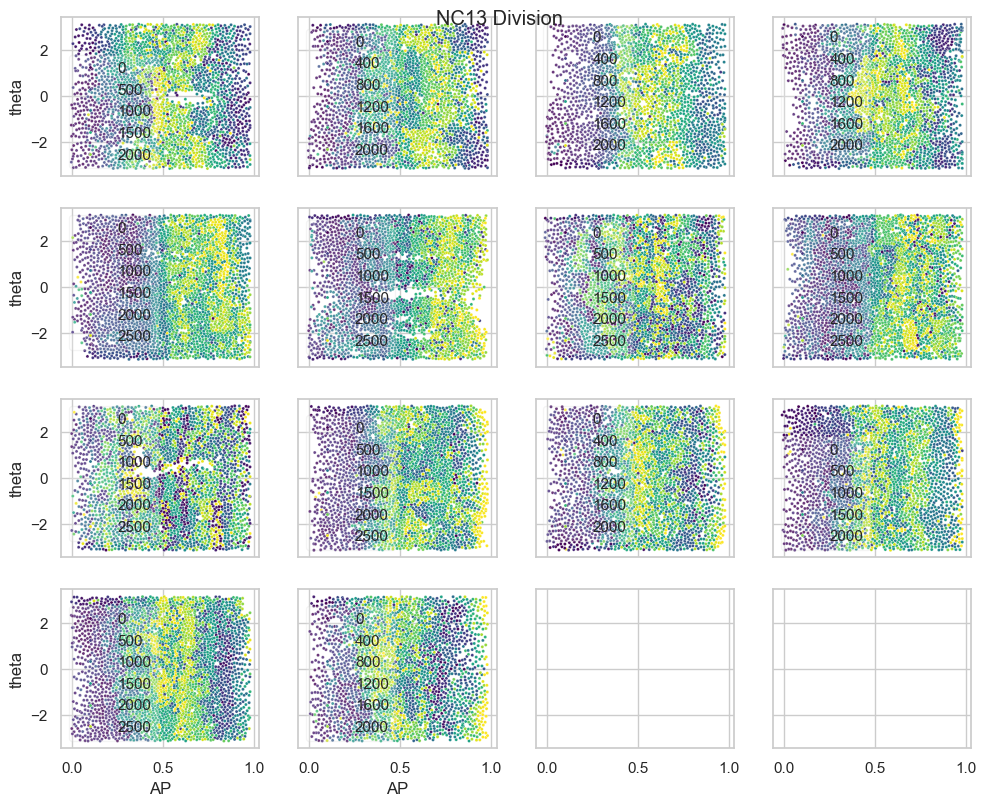

In [73]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(4, 4, figsize=(10, 8), sharex=True, sharey=True)
cycle = 13

plt.tight_layout()


for i, (df, ax) in enumerate(zip(spots_dfs, axes.flatten())):

    trk = df["trk"].min()

    color = pal[int(trk)]

    df = df[df["AP"] < 0.98]
    df = df[df["distance"] < 5]

    for j, cycle in enumerate([13]):

        color = nc_pal[cycle]

        t = df[df["cycle"] == cycle].groupby("tracklet_id")

        x = t["AP"].last()
        y = t["theta"].last()

        val = np.argsort(np.random.permutation(np.array(t["time_since_nc11"].max())))

        sns.scatterplot(x=x, y=y, hue=val, ax=ax, palette="viridis", s=5)


plt.savefig(save_path / f"ap_division_cycle_{cycle}_scatter.png", dpi=300)
plt.suptitle(f"NC{cycle} Division")
#
plt.show()

In [10]:
import napari

viewer = napari.Viewer(ndisplay=3)

sdf = spots_dfs[7]

X = sdf[["frame", "display_x", "display_y", "display_z"]].values
cmap = mpl.colormaps["viridis"]
val = sdf["pseudotime"].fillna(0).values
colors = cmap(val)

size = sdf["radius"] * 2

points = viewer.add_points(
    X, face_color=colors, size=size, name=f"spots_{0}", border_width=1.0, border_width_is_relative=False,
    antialiasing=0.0, border_color="#000000",
)

napari.run()